In [48]:
# from learn_orbital_physics import *
# from lop_anode import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from numpy import exp, log
from torchdiffeq import odeint,odeint_adjoint 

In [13]:
all_planets = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"]

earth_only_list = ["Sun", "Earth"]

telluric_planet = ["Sun", "Mercury", "Venus", "Earth", "Mars"]

# Reference values for nondimensionalization
L_ref = 1.5e11  # Earth-Sun distance in meters
M_ref = 6e24  # Mass of the Earth in kg
T_ref = 3.15e7  # Orbital period of the Earth in seconds (1 year)


In [ ]:
class OrbitalDynamics(nn.Module):
    def __init__(
        self,
        planet_list=earth_only_list,
        ln_mass=None,
        ln_G=None,
        initial_pos=None,
        initial_vel=None,
        augmented_dim=0,
        device=torch.device("cuda"),
    ):
        super().__init__()
        self.planet_list = planet_list
        self.dim = len(self.planet_list)
        self.augmented_dim = augmented_dim
        self.device = device

        if ln_G is not None:
            self.ln_G = ln_G  # Gravitational constant
        else:
            self.ln_G = nn.Parameter(torch.tensor(-19.0))
            
        # Initialize masses (nondimensionalized)
        if ln_mass is not None:
            self.ln_mass = nn.Parameter(ln_mass)  # Log relative masses (with Earth at 0.0)
        else:
            self.ln_mass = nn.Parameter(torch.zeros(self.dim))

        # Initialize positions (nondimensionalized)
        if initial_pos is not None:
            self.initial_pos = initial_pos
        else:
            self.initial_pos = nn.Parameter(
                torch.tensor([[1.0 * i, 0.0, 0.0] for i in range(self.dim)])
            )  # Sun at origin, Earth at 1.0 in x-direction

        # Initialize velocities (nondimensionalized)
        if initial_vel is not None:
            self.initial_vel = initial_vel
        else:
            self.initial_vel = nn.Parameter(
                torch.tensor([[0.0, -6.28 * i, 0.0] for i in range(self.dim)])
            )  # Earth moving in -y direction

        # Define a small auxiliary neural network for augmented dynamics
        if self.augmented_dim > 0:
            self.aux_net = nn.Sequential(
                nn.Linear(3 + augmented_dim, 32),  # Input: state + augmented part
                nn.ReLU(),
                nn.Linear(32, 3 + augmented_dim),
            )  # Output: dynamics for augmented state
        else:
            self.aux_net = None

    def forward(self, t, state):
        # state: tensor of shape (2 * self.dim , 3+ self.augmented_dim)
        # Split state into positions, velocities, and augmented dimensions
        pos = state[: self.dim, : -self.augmented_dim]
        vel = state[self.dim :, : -self.augmented_dim]
        # augmented = state[:, -self.augmented_dim :]

        # Compute pairwise differences
        diff = pos.unsqueeze(0) - pos.unsqueeze(1)  # Shape: (self.dim, self.dim, 3)
        dist = torch.norm(diff, dim=2)  # Shape: (self.dim, self.dim)
        dist_cubed = dist**3 + 1e-10  # Add small epsilon to avoid division by zero
        # Compute gravitational forces (nondimensionalized)
        G = torch.exp(
            self.ln_G - 3 * log(L_ref) + 2 * log(T_ref) + log(M_ref)
        )  ## G (m^3.s^-2.kg^-1) nondimensionalized
        masses = torch.exp(self.ln_mass)
        forces = (
            G * (masses.unsqueeze(0) * masses.unsqueeze(1)).unsqueeze(2) * diff / dist_cubed.unsqueeze(2)
        )  # Shape: (self.dim, self.dim, 3)

        # Sum forces to get the total force on each planet
        total_force = torch.sum(forces, dim=1)  # Shape: (self.dim, 3)

        # Compute acceleration: a = F / m
        dvel = total_force / masses.unsqueeze(1)  # Shape: (self.dim, 3)
        dpos = vel  # Shape: (self.dim, 3)

        derivative = torch.cat([dpos, dvel], dim=0)
        # # Compute dynamics for augmented dimensions using the auxiliary network
        # Concatenate dpos, dvel, and daugmented to form the derivative of the state
        if self.augmented_dim == 1:
            # Concatenate positions and augmented state as input to the auxiliary network
            daugmented = self.aux_net(state)[:, -1].unsqueeze(1)  # Shape: (2*self.dim, augmented_dim)
            return torch.cat([derivative, daugmented], dim=1)
        elif self.augmented_dim > 1:
            daugmented = self.aux_net(state)[:, -self.augmented_dim :]
            return torch.cat([derivative, daugmented], dim=1)
        else:
            return derivative

    def simulate(self, times):
        # Initialize augmented dimensions to zero
        if self.augmented_dim == 0:
            state = torch.cat([self.initial_pos, self.initial_vel], dim=0)
        elif self.augmented_dim > 0:
            # augmented_state = torch.zeros(2 * self.dim, self.augmented_dim).to(self.device)
            augmented_state = torch.randn(2 * self.dim, self.augmented_dim) * 1e-2
            augmented_state = augmented_state.to(self.device)
            original_state = torch.cat([self.initial_pos, self.initial_vel], dim=0)
            state = torch.cat([original_state, augmented_state], dim=1)

        # Observation times (nondimensionalized)
        nondim_times = times / T_ref

        # solution = odeint(self, state, nondim_times, atol=1e-8, rtol=1e-8)
        solution = odeint_adjoint(self, state, nondim_times, atol=1e-10, rtol=1e-10)
        # absolute error and relative error à régler
        trajectory = solution[:, : self.dim, : -self.augmented_dim]  # Extract positions from the solution

        return trajectory


def test_simplified_model():
    # Define the model with augmented dimensions and auxiliary network
    model = OrbitalDynamics(augmented_dim=1)

    # Define time steps for simulation (in seconds)
    days = 365  # Simulate for 1 year
    seconds_per_day = 86400  # Number of seconds in a day
    times = torch.linspace(0, 3 * days * seconds_per_day, 1000)  # 1000 time steps over 1 year

    # Simulate the system
    trajectory = model.simulate(times)

    # Plot the trajectories of both bodies
    plt.figure(figsize=(10, 5))

    # Sun trajectory
    plt.plot(
        trajectory[:, 0, 0].detach().numpy(), trajectory[:, 0, 1].detach().numpy(), ".", label="Sun", color="orange"
    )

    # Earth trajectory
    plt.plot(trajectory[:, 1, 0].detach().numpy(), trajectory[:, 1, 1].detach().numpy(), label="Earth", color="blue")

    plt.xlabel("X Position (km)")
    plt.ylabel("Y Position (km)")
    plt.title("Trajectories of Sun and Earth")
    plt.legend()
    plt.grid()
    plt.show()

torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2, 2, 3])
torch.Size([2, 2, 3])
torch.Size([2, 2])
torch.Size([2,

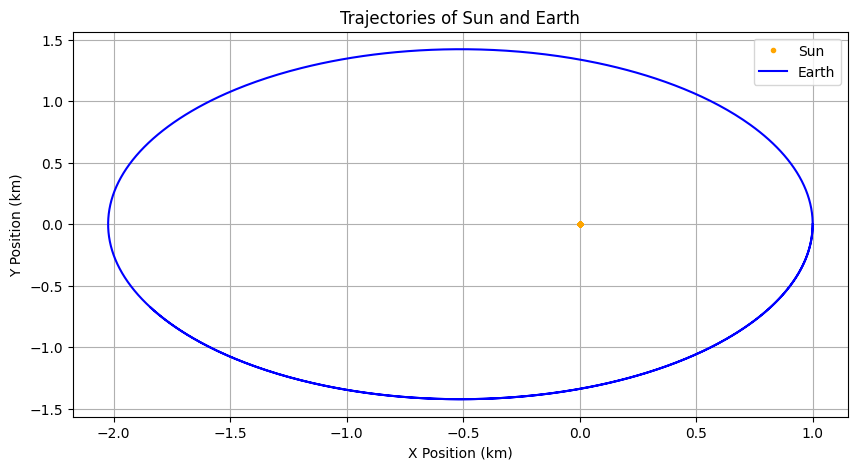

In [2]:
test_simplified_model()

In [21]:
device = torch.device("cuda")
print(device)

def time_series(file):
    file = "csv/" + file  ## à adapter
    table = pd.read_csv(file)
    #print(table.columns)
    table["Date (TDB)"] = pd.to_datetime(table["Date (TDB)"])
    init_date = table["Date (TDB)"].values[0]
    table["Time"] = [(date-init_date).total_seconds() for date in table["Date (TDB)"]]
    #print(table.head(5))
    return table

def time_series_to_tensor(list_series):
    times = torch.Tensor(list_series[0]["Time"])
    pos_tensor = torch.Tensor([[[planet.iloc[time][pos] for pos in ["X (km)","Y (km)", "Z (km)"]] 
                                for planet in list_series] 
                                for time in range(len(list_series[0]))])
    vel_tensor = torch.Tensor([[[planet.iloc[time][vel] for vel in ["VX (km/s)","VY (km/s)", "VZ (km/s)"]] 
                                for planet in list_series] 
                                for time in range(len(list_series[0]))])
    return times/T_ref, pos_tensor/(L_ref/1000), vel_tensor/(L_ref/T_ref/1000)

def relative_squared_error(predicted, observed, eps=1e-6):
    """
    Simple Relative Squared Error (RSE) loss function.
    
    Args:
        predicted (torch.Tensor): Predicted values.
        observed (torch.Tensor): Observed (ground truth) values.
        eps (float): Small constant to avoid division by zero.
    
    Returns:
        torch.Tensor: Relative squared error.
    """
    # Compute squared errors
    squared_errors = (predicted - observed) ** 2
    
    # Normalize by the squared magnitude of the observed values
    relative_errors = squared_errors / (observed ** 2 + eps)
    
    # Compute the mean relative squared error
    return torch.mean(relative_errors)


cuda


In [3]:
planet_list = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter","Saturn", "Uranus"]

planets_series = [time_series(f"{planet}.csv") for planet in planet_list]

In [8]:
[print(planet.head(1)) for planet in planets_series]

  Date (TDB)         X (km)       Y (km)        Z (km)  VX (km/s)  VY (km/s)  \
0 2015-03-05  460384.765567 -76560.36737 -21402.529145   0.006112   0.009831   

   VZ (km/s)  Time  
0  -0.000157   0.0  
  Date (TDB)        X (km)        Y (km)        Z (km)  VX (km/s)  VY (km/s)  \
0 2015-03-05 -2.078082e+07 -6.641862e+07 -3.493347e+06  36.615687 -12.418345   

   VZ (km/s)  Time  
0  -4.374418   0.0  
  Date (TDB)        X (km)        Y (km)        Z (km)  VX (km/s)  VY (km/s)  \
0 2015-03-05  5.528643e+07  9.292540e+07 -1.910690e+06 -30.274879  17.640261   

   VZ (km/s)  Time  
0    1.98897   0.0  
  Date (TDB)        X (km)        Y (km)        Z (km)  VX (km/s)  VY (km/s)  \
0 2015-03-05 -1.420495e+08  4.111963e+07 -22082.108914  -8.746485 -28.708754   

   VZ (km/s)  Time  
0  -0.000066   0.0  
  Date (TDB)        X (km)        Y (km)        Z (km)  VX (km/s)  VY (km/s)  \
0 2015-03-05  1.899863e+08  9.812135e+07 -2.615628e+06 -10.210942  23.593563   

   VZ (km/s)  Time  
0   0.

[None, None, None, None, None, None, None, None]

In [30]:
nb_year = 5
nb_hours = int(nb_year*365.25*24)
hours_step = 24*10

observed_planets = [planet.iloc[0:nb_hours:hours_step] for planet in planets_series]

times, obs_trajectory, obs_vel = time_series_to_tensor(observed_planets)

times = times.to(device)
obs_trajectory = obs_trajectory.to(device)
obs_vel = obs_vel.to(device)


print(times.shape)
print(obs_trajectory.shape)

torch.Size([183])
torch.Size([183, 8, 3])


In [17]:
def display_trajectory(trajectory, ref, planets = planet_list):
    # Plot the trajectories of both bodies
    nb_planet = len(planet_list)

    plt.figure(figsize=(10, 5))

    plt.plot(trajectory[:, 0, 0].detach().cpu().numpy(), trajectory[:, 0, 1].detach().cpu().numpy() , ".", label="Sun")
    plt.plot(ref[:, 0, 0].detach().cpu().numpy(), ref[:, 0, 1].detach().cpu().numpy(), ".", label=f"Actual Sun")
    
    for i in range(1, nb_planet):
        plt.plot(trajectory[:, i, 0].detach().cpu().numpy(), trajectory[:, i, 1].detach().cpu().numpy() , label=planets[i])
        plt.plot(ref[:, i, 0].detach().cpu().numpy(), ref[:, i, 1].detach().cpu().numpy(), '--', label=f"Actual {planets[i]}")

    plt.xlabel("X Position (km)")
    plt.ylabel("Y Position (km)")
    plt.title("Trajectories of Sun and Earth")
    plt.legend()
    plt.grid()
    plt.show()

In [62]:
def train_anode(num_epochs, lr, initial_pos, initial_vel, planet_list, augmented_dim, ):
    model = OrbitalDynamics(initial_pos=initial_pos, initial_vel=initial_vel,
                        planet_list = planet_list, augmented_dim = augmented_dim)
    model.to(device)
    model.train()
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.9)
    loss_fn = relative_squared_error

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Simulate the trajectories using the current model parameters
        simulated_trajectory = model.simulate(times[:20])
        simulated_trajectory.to(device)
        obs_trajectory.to(device)
        # Extract simulated positions and velocities
        # simulated_positions = simulated_trajectory[:, :, :3]  # Shape: (num_times, num_planets, 3)
        # simulated_velocities = simulated_trajectory[:, :, 3:]  # Shape: (num_times, num_planets, 3)
        # Compute the loss between observed and simulated data
        loss = loss_fn(simulated_trajectory[:20], obs_trajectory[:20])
        
        # Backpropagate and update parameters
        loss.backward()

        optimizer.step()

        # Adjust learning rate if loss is below the threshold
        if loss.item() < 0.02:
            for param_group in optimizer.param_groups:
                    param_group['lr'] = 0.001  # Change learning rate to 0.01

        # Print loss for monitoring
        if (epoch+1) % 20 == 0:
            display_trajectory(simulated_trajectory, obs_trajectory, model.planet_list)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}")

    print("Training complete.")
    return model


In [60]:
model = train_anode(100,0.1,obs_trajectory[0], obs_vel[0], planet_list, 1)

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [56]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.data}")

ln_G: -19.0
ln_mass: tensor([ 1.3396e-07, -1.1908e-07,  6.9404e-08,  2.7671e-08, -7.9613e-10,
         1.4037e-09, -4.3426e-10,  1.6310e-11], device='cuda:0')
aux_net.0.weight: tensor([[ 0.1796, -0.0650, -0.4718,  0.0470],
        [ 0.3504, -0.4349, -0.3203, -0.0682],
        [ 0.3686,  0.4469, -0.4016, -0.1991],
        [-0.3397, -0.4346, -0.4613,  0.3562],
        [ 0.0751, -0.4110,  0.3489, -0.3580],
        [ 0.4451,  0.2911, -0.0490, -0.0523],
        [-0.0325,  0.3503,  0.2744,  0.1866],
        [-0.3231, -0.3616,  0.2379,  0.1950],
        [-0.2868, -0.4131, -0.2987,  0.2797],
        [ 0.3244,  0.0765, -0.2840, -0.2920],
        [ 0.1285, -0.0378,  0.1263, -0.1155],
        [-0.4023, -0.3187, -0.2348, -0.3366],
        [-0.2998, -0.1837, -0.1554, -0.0187],
        [-0.1604,  0.4905, -0.3893,  0.0241],
        [-0.1045, -0.4249,  0.3706, -0.0801],
        [-0.4967, -0.3839,  0.0563,  0.4700],
        [ 0.2937,  0.0226,  0.2554, -0.3963],
        [ 0.1851, -0.4689,  0.3732,  0.28